In [31]:
from custom_layers import Conv1D_zerophase_linear, Conv1D_linearphase, Conv1D_zerophase,\
    DCT1D, Conv1D_gammatone, Conv1D_linearphaseType, Attention
from keras.layers import Input, Conv1D, MaxPooling1D, Dense, Dropout, Flatten, Activation, AveragePooling1D, Add
from keras import initializers
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.layers.core import Lambda
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.optimizers import Adam, SGD # Nadam, Adamax
import numpy as np
import tables,h5py
from Gradient_Reverse_Layer import GradientReversal
from ResultAnalyser import Result
from utils import Confused_Crossentropy
from keras.utils import plot_model
from keras import backend as K

In [63]:
loadpath = None
num_filt = (8, 4)
num_dense = 20
lr = 0.01
bn_momentum = 0.99
eps = 1.1e-5
bias = False
l2_reg = 0.04864911065093751
l2_reg_dense = 0.
kernel_size = 5
print("Agge 5 cilo ")
maxnorm = 10000.
dropout_rate = 0.5
dropout_rate_dense = 0.
padding = 'valid'
activation_function = 'relu'
subsam = 2
FIR_train= True
trainable = True
hp_lambda = np.float32(0)
lr_decay =0.0001132885
random_seed = 1
num_class =2
num_class_domain = 18
tipe= 1
decision = 'majority' 

Agge 5 cilo 


In [44]:
def branch(input_tensor,num_filt,kernel_size,random_seed,padding,bias,maxnorm,l2_reg,
           eps,bn_momentum,activation_function,dropout_rate,subsam,trainable):

    num_filt1, num_filt2 = num_filt
    t = Conv1D(num_filt1, kernel_size=kernel_size,
                kernel_initializer=initializers.he_normal(seed=random_seed),
                padding=padding,
                use_bias=bias,
                kernel_constraint=max_norm(maxnorm),
                trainable=trainable,
                kernel_regularizer=l2(l2_reg))(input_tensor)
    t = BatchNormalization(epsilon=eps, momentum=bn_momentum, axis=-1)(t)
    t = Activation(activation_function)(t)
    t = Dropout(rate=dropout_rate, seed=random_seed)(t)
    return t
def zeropad(x):
    y = K.zeros_like(x)
    return K.concatenate([x, y], axis=2)

def zeropad_output_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 3
    shape[2] *= 2
    return tuple(shape)

In [81]:
def heartnet(load_path,activation_function='relu', bn_momentum=0.99, bias=False, dropout_rate=0.5, dropout_rate_dense=0.0,
             eps=1.1e-5, kernel_size=5, l2_reg=0.0, l2_reg_dense=0.0,lr=0.0012843784, lr_decay=0.0001132885, maxnorm=10000.,
             padding='valid', random_seed=1, subsam=2, num_filt=(8, 4), num_dense=20,FIR_train=False,trainable=True,type=1,
             num_class=2, num_class_domain=1,hp_lambda=0,batch_size=1024):
    
    #num_dense = 20 default 
    input = Input(shape=(2500, 1))

    coeff_path = '../data/filterbankcoeff60.mat'
    coeff = tables.open_file(coeff_path)
    b1 = coeff.root.b1[:]
    b1 = np.hstack(b1)
    b1 = np.reshape(b1, [b1.shape[0], 1, 1])

    b2 = coeff.root.b2[:]
    b2 = np.hstack(b2)
    b2 = np.reshape(b2, [b2.shape[0], 1, 1])

    b3 = coeff.root.b3[:]
    b3 = np.hstack(b3)
    b3 = np.reshape(b3, [b3.shape[0], 1, 1])

    b4 = coeff.root.b4[:]
    b4 = np.hstack(b4)
    b4 = np.reshape(b4, [b4.shape[0], 1, 1])

    ## Conv1D_linearphase

    # input1 = Conv1D_linearphase(1 ,61, use_bias=False,
    #                 # kernel_initializer=initializers.he_normal(random_seed),
    #                 weights=[b1[30:]],
    #                 padding='same',trainable=FIR_train)(input)
    # input2 = Conv1D_linearphase(1, 61, use_bias=False,
    #                 # kernel_initializer=initializers.he_normal(random_seed),
    #                 weights=[b2[30:]],
    #                 padding='same',trainable=FIR_train)(input)
    # input3 = Conv1D_linearphase(1, 61, use_bias=False,
    #                 # kernel_initializer=initializers.he_normal(random_seed),
    #                 weights=[b3[30:]],
    #                 padding='same',trainable=FIR_train)(input)
    # input4 = Conv1D_linearphase(1, 61, use_bias=False,
    #                 # kernel_initializer=initializers.he_normal(random_seed),
    #                 weights=[b4[30:]],
    #                 padding='same',trainable=FIR_train)(input)

    ## Conv1D_linearphase Anti-Symmetric
    #
    input1 = Conv1D_linearphaseType(1 ,60, use_bias=False,
                    # kernel_initializer=initializers.he_normal(random_seed),
                    weights=[b1[31:]],
                    padding='same',trainable=FIR_train, type = type)(input)
    input2 = Conv1D_linearphaseType(1, 60, use_bias=False,
                    # kernel_initializer=initializers.he_normal(random_seed),
                    weights=[b2[31:]],
                    padding='same',trainable=FIR_train, type = type)(input)
    input3 = Conv1D_linearphaseType(1, 60, use_bias=False,
                    # kernel_initializer=initializers.he_normal(random_seed),
                    weights=[b3[31:]],
                    padding='same',trainable=FIR_train, type = type)(input)
    input4 = Conv1D_linearphaseType(1, 60, use_bias=False,
                    # kernel_initializer=initializers.he_normal(random_seed),
                    weights=[b4[31:]],
                    padding='same',trainable=FIR_train, type = type)(input)
    t1 = branch(input1,num_filt,kernel_size,random_seed,padding,bias,maxnorm,l2_reg,
           eps,bn_momentum,activation_function,dropout_rate,subsam,trainable)
    t2 = branch(input2,num_filt,kernel_size,random_seed,padding,bias,maxnorm,l2_reg,
           eps,bn_momentum,activation_function,dropout_rate,subsam,trainable)
    t3 = branch(input3,num_filt,kernel_size,random_seed,padding,bias,maxnorm,l2_reg,
           eps,bn_momentum,activation_function,dropout_rate,subsam,trainable)
    t4 = branch(input4,num_filt,kernel_size,random_seed,padding,bias,maxnorm,l2_reg,
           eps,bn_momentum,activation_function,dropout_rate,subsam,trainable)
    #Conv1D_gammatone

    # input1 = Conv1D_gammatone(kernel_size=81,filters=1,fsHz=1000,use_bias=False,padding='same')(input)
    # input2 = Conv1D_gammatone(kernel_size=81,filters=1,fsHz=1000,use_bias=False,padding='same')(input)
    # input3 = Conv1D_gammatone(kernel_size=81,filters=1,fsHz=1000,use_bias=False,padding='same')(input)
    # input4 = Conv1D_gammatone(kernel_size=81,filters=1,fsHz=1000,use_bias=False,padding='same')(input)
    
    xx = Concatenate(axis=-1)([t1,t2,t3,t4])
    
    xx = res_block(xx,64,kernel_size,2,'same',random_seed,bias,maxnorm,l2_reg,
           eps,bn_momentum,activation_function,dropout_rate,subsam,trainable)
    xx = res_block(xx,64,kernel_size,1,'same',random_seed,bias,maxnorm,l2_reg,
           eps,bn_momentum,activation_function,dropout_rate,subsam,trainable)
    
    xx = res_block(xx,128,kernel_size,3,'same',random_seed,bias,maxnorm,l2_reg,
           eps,bn_momentum,activation_function,dropout_rate,subsam,trainable)
    xx = res_block(xx,128,kernel_size,1,'same',random_seed,bias,maxnorm,l2_reg,
           eps,bn_momentum,activation_function,dropout_rate,subsam,trainable)
    
    xx = res_block(xx,256,kernel_size,2,'same',random_seed,bias,maxnorm,l2_reg,
           eps,bn_momentum,activation_function,dropout_rate,subsam,trainable)
    xx = res_block(xx,256,kernel_size,1,'same',random_seed,bias,maxnorm,l2_reg,
           eps,bn_momentum,activation_function,dropout_rate,subsam,trainable)
    
    xx = res_block(xx,256,kernel_size,2,'same',random_seed,bias,maxnorm,l2_reg,
           eps,bn_momentum,activation_function,dropout_rate,subsam,trainable,cat=False)
    xx = res_block(xx,256,kernel_size,2,'same',random_seed,bias,maxnorm,l2_reg,
           eps,bn_momentum,activation_function,dropout_rate,subsam,trainable,cat=False)
    
    xx = Conv1D(256, kernel_size=kernel_size,
                kernel_initializer=initializers.he_normal(seed=random_seed),
                padding=padding,
                strides=2,
                use_bias=bias,
                kernel_constraint=max_norm(maxnorm),
                trainable=trainable,
                kernel_regularizer=l2(l2_reg))(xx)
    
    merged = Flatten()(xx)
    
    dann_in = GradientReversal(hp_lambda=hp_lambda,name='grl')(merged)
    dsc = Dense(50,
                   activation=activation_function,
                   kernel_initializer=initializers.he_normal(seed=random_seed),
                   use_bias=bias,
                   kernel_constraint=max_norm(maxnorm),
                   kernel_regularizer=l2(l2_reg_dense),
                   name = 'domain_dense')(dann_in)   
    dsc = Dense(num_class_domain, activation='softmax', name = "domain")(dsc)          
    merged = Dense(num_dense,
                   activation=activation_function,
                   kernel_initializer=initializers.he_normal(seed=random_seed),
                   use_bias=bias,
                   kernel_constraint=max_norm(maxnorm),
                   kernel_regularizer=l2(l2_reg_dense),
                   name = 'class_dense')(merged)
    merged = Dense(num_class, activation='softmax', name="class")(merged)
    
    model = Model(inputs=input, outputs=[merged,dsc])
    
    if load_path:
        model.load_weights(filepath=load_path, by_name=False)
    
    #if load_path:  # If path for loading model was specified
    #model.load_weights(filepath='../../models_dbt_dann/fold_a_gt 2019-09-09 16:53:52.063276/weights.0041-0.6907.hdf5', by_name=True)
    # models/fold_a_gt 2019-09-04 17:36:52.860817/weights.0200-0.7135.hdf5
    
    #if optim=='Adam':
    #    opt = Adam(lr=lr, decay=lr_decay)
    #else:  
    opt = SGD(lr=lr,decay=lr_decay)
    model.compile(optimizer=opt, loss={'class':'categorical_crossentropy','domain':'categorical_crossentropy'}, metrics=['accuracy'])
    return model

In [82]:
def res_block(input_tensor,num_filt,kernel_size,stride,padding,random_seed,bias,maxnorm,l2_reg,
           eps,bn_momentum,activation_function,dropout_rate,subsam,trainable,cat=True):

    t = Conv1D(num_filt, kernel_size=kernel_size,
                kernel_initializer=initializers.he_normal(seed=random_seed),
                padding=padding,
                strides=stride,
                use_bias=bias,
                kernel_constraint=max_norm(maxnorm),
                trainable=trainable,
                kernel_regularizer=l2(l2_reg))(input_tensor)
    t = BatchNormalization(epsilon=eps, momentum=bn_momentum, axis=-1)(t)
    t = Activation(activation_function)(t)
    t = Dropout(rate=dropout_rate, seed=random_seed)(t)
    print(t.shape)
    t = Conv1D(num_filt, kernel_size=kernel_size,
                kernel_initializer=initializers.he_normal(seed=random_seed),
                padding=padding,
                strides=1,
                use_bias=bias,
                kernel_constraint=max_norm(maxnorm),
                trainable=trainable,
                kernel_regularizer=l2(l2_reg))(t)
    t = BatchNormalization(epsilon=eps, momentum=bn_momentum, axis=-1)(t)
    t = Activation(activation_function)(t)
    t = Dropout(rate=dropout_rate, seed=random_seed)(t)
    
    p = MaxPooling1D(pool_size=stride)(input_tensor)
    if(stride>1):
        if(cat):
            p = Lambda(zeropad, output_shape=zeropad_output_shape)(p)
    print(t.shape)
    print(p.shape)
    
    t = Add()([t,p])
    return t

In [83]:
52/3

17.333333333333332

In [84]:
model = heartnet(loadpath,activation_function, bn_momentum, bias, dropout_rate, dropout_rate_dense,
                             eps, kernel_size, l2_reg, l2_reg_dense, lr, lr_decay, maxnorm,
                             padding, random_seed, subsam, num_filt, num_dense, FIR_train, trainable, tipe,
                             num_class=num_class,num_class_domain=9,hp_lambda=hp_lambda)

(?, 1248, 64)
(?, 1248, 64)
(?, 1248, 64)
(?, 1248, 64)
(?, 1248, 64)
(?, 1248, 64)
(?, 416, 128)
(?, 416, 128)
(?, 416, 128)
(?, 416, 128)
(?, 416, 128)
(?, 416, 128)
(?, 208, 256)
(?, 208, 256)
(?, 208, 256)
(?, 208, 256)
(?, 208, 256)
(?, 208, 256)
(?, 104, 256)
(?, 104, 256)
(?, 104, 256)
(?, 52, 256)
(?, 52, 256)
(?, 52, 256)


In [85]:
plot_model(model, to_file='model_test.png', show_shapes=True)
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 2500, 1)      0                                            
__________________________________________________________________________________________________
conv1d_linearphase_type_41 (Con (None, 2500, 1)      30          input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_linearphase_type_42 (Con (None, 2500, 1)      30          input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_linearphase_type_43 (Con (None, 2500, 1)      30          input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_lin

In [10]:
coeff_path = '../data/filterbankcoeff60.mat'
coeff = tables.open_file(coeff_path)
b1 = coeff.root.b1[:]
b1 = np.hstack(b1)
b1 = np.reshape(b1, [b1.shape[0], 1, 1])

b2 = coeff.root.b2[:]
b2 = np.hstack(b2)
b2 = np.reshape(b2, [b2.shape[0], 1, 1])

b3 = coeff.root.b3[:]
b3 = np.hstack(b3)
b3 = np.reshape(b3, [b3.shape[0], 1, 1])

b4 = coeff.root.b4[:]
b4 = np.hstack(b4)
b4 = np.reshape(b4, [b4.shape[0], 1, 1])

In [11]:
3,760,013

File(filename=../data/filterbankcoeff60.mat, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/N (Array(1, 1)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/b1 (Array(61, 1)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/b2 (Array(61, 1)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/b3 (Array(61, 1)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/b4 (Array(61, 1)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None

In [14]:
from keras import backend as K

def _bn_relu(layer, dropout=0, **params):
    from keras.layers import BatchNormalization
    from keras.layers import Activation
    layer = BatchNormalization()(layer)
    layer = Activation(params["conv_activation"])(layer)

    if dropout > 0:
        from keras.layers import Dropout
        layer = Dropout(params["conv_dropout"])(layer)

    return layer

def add_conv_weight(
        layer,
        filter_length,
        num_filters,
        subsample_length=1,
        **params):
    from keras.layers import Conv1D 
    layer = Conv1D(
        filters=num_filters,
        kernel_size=filter_length,
        strides=subsample_length,
        padding='same',
        kernel_initializer=params["conv_init"])(layer)
    return layer


def add_conv_layers(layer, **params):
    for subsample_length in params["conv_subsample_lengths"]:
        layer = add_conv_weight(
                    layer,
                    params["conv_filter_length"],
                    params["conv_num_filters_start"],
                    subsample_length=subsample_length,
                    **params)
        layer = _bn_relu(layer, **params)
    return layer

def resnet_block(
        layer,
        num_filters,
        subsample_length,
        block_index,
        **params):
    from keras.layers import Add 
    from keras.layers import MaxPooling1D
    from keras.layers.core import Lambda

    def zeropad(x):
        y = K.zeros_like(x)
        return K.concatenate([x, y], axis=2)

    def zeropad_output_shape(input_shape):
        shape = list(input_shape)
        assert len(shape) == 3
        shape[2] *= 2
        return tuple(shape)

    shortcut = MaxPooling1D(pool_size=subsample_length)(layer)
    zero_pad = (block_index % params["conv_increase_channels_at"]) == 0 \
        and block_index > 0
    if zero_pad is True:
        shortcut = Lambda(zeropad, output_shape=zeropad_output_shape)(shortcut)

    for i in range(params["conv_num_skip"]):
        if not (block_index == 0 and i == 0):
            layer = _bn_relu(
                layer,
                dropout=params["conv_dropout"] if i > 0 else 0,
                **params)
        layer = add_conv_weight(
            layer,
            params["conv_filter_length"],
            num_filters,
            subsample_length if i == 0 else 1,
            **params)
    layer = Add()([shortcut, layer])
    return layer

def get_num_filters_at_index(index, num_start_filters, **params):
    return 2**int(index / params["conv_increase_channels_at"]) \
        * num_start_filters

def add_resnet_layers(layer, **params):
    layer = add_conv_weight(
        layer,
        params["conv_filter_length"],
        params["conv_num_filters_start"],
        subsample_length=1,
        **params)
    layer = _bn_relu(layer, **params)
    for index, subsample_length in enumerate(params["conv_subsample_lengths"]):
        num_filters = get_num_filters_at_index(
            index, params["conv_num_filters_start"], **params)
        layer = resnet_block(
            layer,
            num_filters,
            subsample_length,
            index,
            **params)
    layer = _bn_relu(layer, **params)
    return layer

def add_output_layer(layer, **params):
    from keras.layers.core import Dense, Activation
    from keras.layers.wrappers import TimeDistributed
    print(layer)
    layer = TimeDistributed(Dense(params["num_categories"]))(layer)
    return Activation('softmax')(layer)
def add_output_Flatten(layer,**params):
    from keras.layers import Flatten
    from keras.layers.core import Dense, Activation
    layer = Flatten()(layer)
    layer = Dense(params["num_categories"])(layer)
    return layer

def add_compile(model, **params):
    from keras.optimizers import Adam
    optimizer = Adam(
        lr=params["learning_rate"],
        clipnorm=params.get("clipnorm", 1))

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

def build_network(**params):
    from keras.models import Model
    from keras.layers import Input
    print("Hellow motherfucker")
    inputs = Input(shape=params['input_shape'],
                   dtype='float32',
                   name='inputs')

    if params.get('is_regular_conv', False):
        layer = add_conv_layers(inputs, **params)
    else:
        layer = add_resnet_layers(inputs, **params)

    #output = add_output_layer(layer, **params)
    output = add_output_Flatten(layer,**params)

    model = Model(inputs=[inputs], outputs=[output])
    if params.get("compile", True):
        add_compile(model, **params)
    return model


In [15]:
params = {
    "input_shape":(256,1),
    "num_categories":2,
    "conv_subsample_lengths": [1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2],
    #"conv_subsample_lengths": [1, 2, 1, 2, 1, 2, 1, 2],
    "conv_filter_length": 16,
    "conv_num_filters_start": 32,
    "conv_init": "he_normal",
    "conv_activation": "relu",
    "conv_dropout": 0.2,
    "conv_num_skip": 2,
    "conv_increase_channels_at": 4,

    "learning_rate": 0.001,
    "batch_size": 128,

    "train": "examples/irhythm/train.json",
    "dev": "examples/irhythm/dev.json",
    "save_dir": "saved"
}


In [16]:
model = build_network(**params)

Hellow motherfucker


In [17]:
plot_model(model, to_file='model_Resnet.png', show_shapes=True)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 256, 1)       0                                            
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 256, 32)      544         inputs[0][0]                     
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 256, 32)      128         conv1d_5[0][0]                   
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 256, 32)      0           batch_normalization_5[0][0]      
__________________________________________________________________________________________________
conv1d_6 (

In [115]:
import numpy as np, matplotlib.pyplot as plt,math
import sys
eps = sys.float_info.epsilon

In [31]:
p22 = (-12,12)
p33 = (-12,-12)
p44 = (12,-12)
p11 = (12,12)

In [39]:
o = (0,0)
p1 = (4,5)
p2 = (12,12)

In [144]:
def rotate(origin, point, angle=90):
    ox, oy = origin
    px, py = point
    qx = ox + math.cos(math.radians(angle)) * (px - ox) - math.sin(math.radians(angle)) * (py - oy)
    qy = oy + math.sin(math.radians(angle)) * (px - ox) + math.cos(math.radians(angle)) * (py - oy)
    return qx, qy

In [145]:
def getXpoint(p1,p2,dist):
    m = (p2[1]-p1[1])/(p2[0]-p1[0]+eps)
    d = (math.atan(m))
    if(p2[0]>p1[0]):
        x = p1[0]+dist*math.cos(abs(d))
    elif(p2[0]<p1[0]):
        x = p1[0]-dist*math.cos(abs(d))
    else: x = p1[0]
    if(p2[1]>p1[1]):
        y = p1[1]+dist*math.sin(abs(d))
    elif(p2[1]<p1[1]):
        y = p1[1]-dist*math.sin(abs(d))
    else: y = p1[1]
    return x,y
def getX2point(p1,p2,p):
    x = p2[0] + (p[0]-p1[0])
    y = p2[1] + (p[1]-p1[1])
    return x,y

In [148]:
p2 = (20,5)
pout = rotate(p1,getXpoint(p1,p2,4))
pout2 = getX2point(p1,p2,pout)

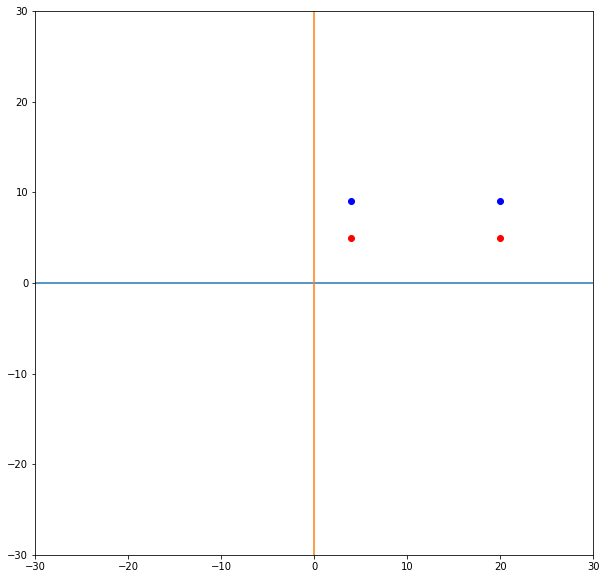

In [154]:
x = [x for (x,y) in [p1,p2]]
y = [y for (x,y) in [p1,p2]]
x2 = [x for (x,y) in [pout,pout2]]
y2 = [y for (x,y) in [pout,pout2]]
D = 30
plt.figure(figsize=(10,10))
plt.plot([-D,D],[0,0])
plt.plot([0,0],[-D,D])
plt.plot(x,y,'ro')
plt.plot(x2,y2,'bo')
plt.axis([-D, D, -D, D])
plt.show()